## Image classification with Convolutional Neural Networks

CNN to solve Dogs vs Cats Kaggle competition

The dataset is available at http://files.fast.ai/data/dogscats.zip.
You should put the data in a subdirectory of this notebook's directory, called data/

In [1]:
# Notebook's automatic reloading(imports) and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# main external libs
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# Nvidia Cuda Framework support
torch.cuda.is_available()

True

In [4]:
# Nvidia CuDNN support
torch.backends.cudnn.enabled

True

In [5]:
# `sz` is the size that the images will be resized to.(trains quickly)
PATH = "../../../data/dogscats/"
sz = 224

In [6]:
# List directory 'dogscats' contents
os.listdir(PATH)

['models', 'test1', 'valid', 'sample', 'train']

In [7]:
# List directory 'dogscats/valid' contents
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [8]:
# List directory 'dogscats/valid/cats' contents(five rows/five files)
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.5931.jpg',
 'cat.2734.jpg',
 'cat.5353.jpg',
 'cat.2229.jpg',
 'cat.10145.jpg']

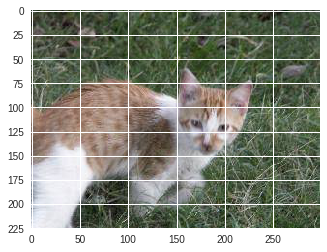

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [10]:
# (M, N, 3)
img.shape

(225, 299, 3)

In [11]:
img[:4, :4]

array([[[43, 57, 44],
        [49, 63, 50],
        [57, 71, 58],
        [62, 76, 61]],

       [[37, 51, 38],
        [51, 65, 52],
        [68, 82, 67],
        [75, 87, 73]],

       [[38, 50, 36],
        [54, 66, 52],
        [71, 84, 67],
        [74, 87, 70]],

       [[48, 59, 43],
        [54, 65, 49],
        [62, 71, 54],
        [61, 70, 53]]], dtype=uint8)

In [12]:
# shutil directory manipulation(rmtree for tree tmp) commented
arch = resnet34
# Initializes a ImageClassifierData object
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))
# Get a pretrained CNN model
learn = ConvLearner.pretrained(arch, data, precompute=True)
# Fit model to the data(), returns a call to ConvLearner.fit_gen()
# learning rate, number of cycles are passed
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 24402086.57it/s]


100%|██████████| 32/32 [00:16<00:00,  2.00it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.0511     0.029259   0.9905    
    1      0.038029   0.028775   0.989     



[array([0.02877]), 0.989]

In [13]:
#Acutal labels of images
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
#1000 dogs and 1000 cat photos
(data.val_y).shape

(2000,)

In [15]:
#Validation data Arrangement: [1000 cats + 1000 dogs] cats -> dogs
(data.val_y)[990:1010]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
# .predict gives [x, x] <- [cats, dogs] ~ higher value of any x -> strong prob(log)
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [17]:
# Probability(log) confidence shift when transitioning from cats to dogs images
log_preds[990:1010]

array([[ -0.00001, -11.23354],
       [ -0.00008,  -9.48109],
       [ -0.00021,  -8.45414],
       [ -0.00228,  -6.0827 ],
       [ -0.00004, -10.14716],
       [ -0.03965,  -3.24753],
       [ -0.00002, -10.7736 ],
       [ -0.00004, -10.03973],
       [ -0.00007,  -9.60916],
       [ -0.00002, -10.63303],
       [ -4.6048 ,  -0.01005],
       [ -9.57157,  -0.00007],
       [ -7.70776,  -0.00045],
       [ -6.88216,  -0.00103],
       [ -9.80408,  -0.00006],
       [ -4.80613,  -0.00821],
       [ -4.25474,  -0.0143 ],
       [ -7.19467,  -0.00075],
       [ -4.13305,  -0.01616],
       [ -9.84513,  -0.00005]], dtype=float32)

In [18]:
# Axis = 0 is column wise
# Axis = 1 is row wise
# It specifies the axis along which the "something" is computed.
# Argmax gives the coloum index for the highest between the eg: [3, 2] -> 1(idx)
preds = np.argmax(log_preds, axis = 1)
# Log preds in this case are done on base 10 or 2
# Do log preds on base e -> 2.7 to get probabilites(just a number betn 0 and 1)
probs = np.exp(log_preds[:, 1]) #pr(dog)
probs[998:1003] # below shows increase in probablity with image transitions

array([0.00007, 0.00002, 0.99   , 0.99993, 0.99955], dtype=float32)

In [19]:
preds[998:1003]

array([0, 0, 1, 1, 1])

In [20]:
# np.random.choice(condition, length, replace)
# Returns a tuple for 4 ndarrays
# Where return index of places where condition is true
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

In [21]:
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

In [22]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    # Prepare the figure
    f = plt.figure(figsize=figsize)
    # loop over len(img(3d ndarray)) elements
    for i in range(len(ims)):
        # Add Subplot Area
        # add_subplot(nrows, ncols, index, **kwargs)
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [23]:
(preds == data.val_y).shape

(2000,)

In [24]:
# Example (True when equal and False when not equal)
random_corrects = (np.array([0, 0, 0, 0, 1]) == np.array([0, 0, 0, 1, 1])) == True
random_corrects

array([ True,  True,  True, False,  True])

In [25]:
random_incorrects = (np.array([0, 0, 0, 0, 1]) == np.array([0, 0, 0, 1, 1])) == False
random_incorrects

array([False, False, False,  True, False])

In [26]:
type(preds)

numpy.ndarray

In [27]:
# Number of Incorrect and Correct Classifications
unique, counts = np.unique((preds == data.val_y)==True, return_counts=True)
dict(zip(unique, counts))

{False: 22, True: 1978}

In [28]:
# Where return index of places where condition is true
np.random.choice(np.where((preds == data.val_y)==True)[0], min(len(preds), 4), replace=False)

array([ 302, 1251, 1280, 1811])

In [29]:
# Uses Pillow(image loading lib)
# loads and reads image from path and returns the image(3d ndarray)
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Returns a call to Plots sending array of img(ndarray), titles and other params
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs)>0 else print('Not Found.') 

Correctly classified


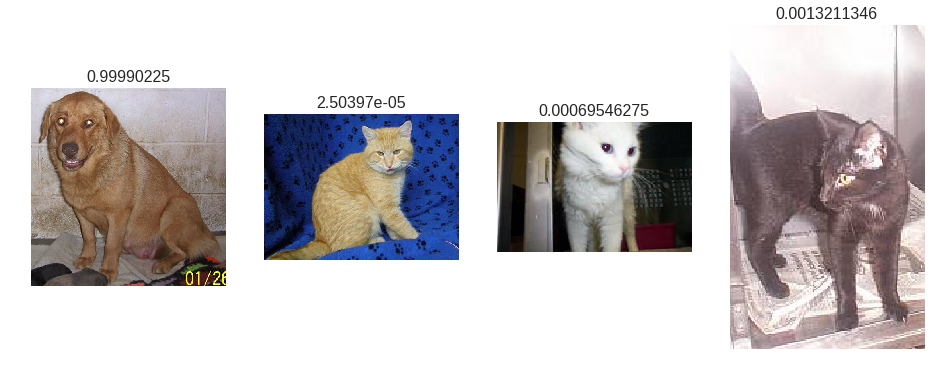

In [30]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


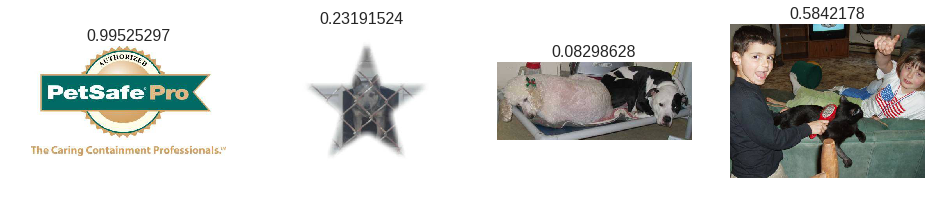

In [31]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [32]:
# Mult (fold effect -> 1 -> -1)
# Cat(0, True) -> 1
# Cat(0, False) -> -1
# Dog(1, True) -> -1
# Dog(1, False) -> 1

In [33]:
# All correct(True) for cats
# Incorrect preds will be false, but also all the dog preds will be false 
(preds == data.val_y)==True & (data.val_y == 0)

array([ True,  True,  True, ..., False, False, False])

In [34]:
unique1, counts1 = np.unique((preds == data.val_y)==True & (data.val_y == 0), return_counts=True)
dict(zip(unique1, counts1))

{False: 994, True: 1006}

In [35]:
# All in-correct(False) for cats
(preds == data.val_y)==False & (data.val_y == 0)

array([False, False, False, ..., False, False, False])

In [36]:
unique2, counts2 = np.unique((preds == data.val_y)==False & (data.val_y == 0), return_counts=True)
dict(zip(unique2, counts2))

{False: 1978, True: 22}

In [37]:
# All correct(True) for Dogs
# Incorrect preds will be false, but also all the Cat preds will be false 
(preds == data.val_y)==True & (data.val_y == 1)

array([False, False, False, ...,  True,  True,  True])

In [38]:
unique3, counts3 = np.unique((preds == data.val_y)==True & (data.val_y == 1), return_counts=True)
dict(zip(unique3, counts3))

{False: 1006, True: 994}

In [39]:
# All in-correct(False) for Dogs
(preds == data.val_y)==False & (data.val_y == 1)

array([False, False, False, ..., False, False, False])

In [40]:
unique4, counts4 = np.unique((preds == data.val_y)==False & (data.val_y == 1), return_counts=True)
dict(zip(unique4, counts4))

{False: 1978, True: 22}

In [41]:
# Quicksort sort from lowest to highest according to the probabilites
# Consider probabilities of idxs
# argsort sorts probabilities and returns the index according to the sort
# access idxs according to the sorted indexes
# A folding trick is applied to obtain correct and incorrect(using 'mult' 1, -1)
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [42]:
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


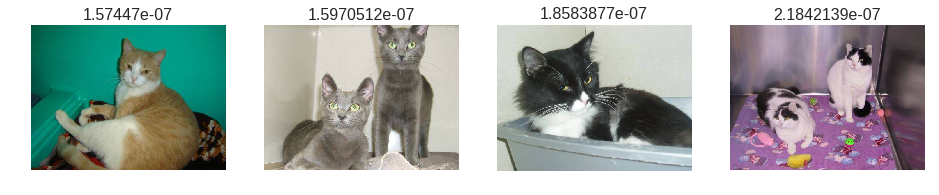

In [43]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


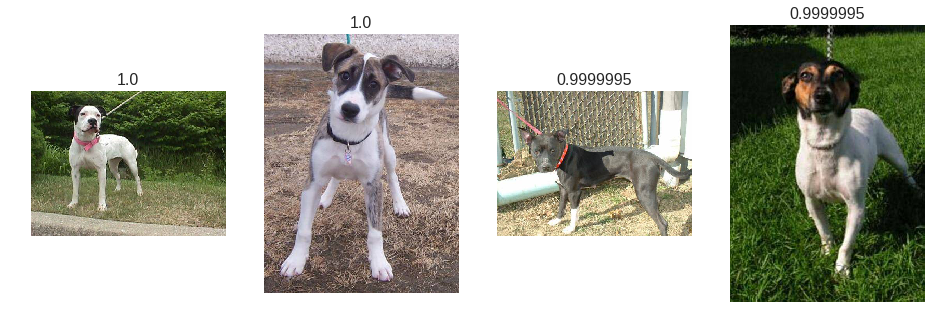

In [44]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most in-correct cats


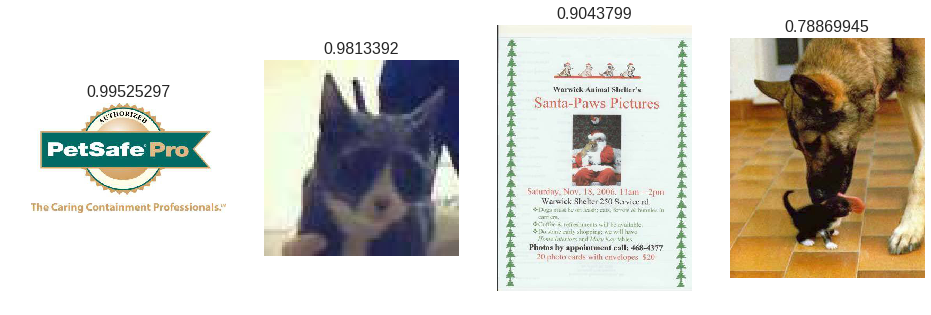

In [45]:
plot_val_with_title(most_by_correct(0, False), "Most in-correct cats")

Most incorrect dogs


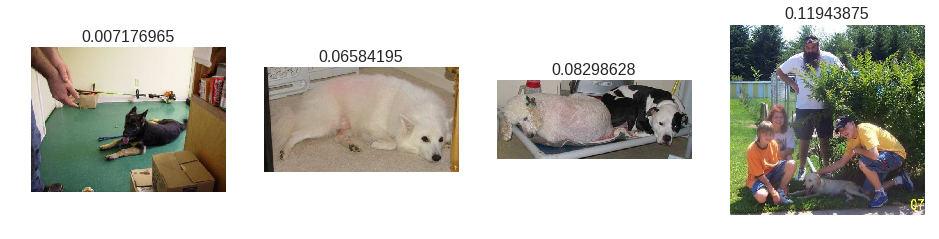

In [46]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [47]:
probs[995:1005]

array([0.03887, 0.00002, 0.00004, 0.00007, 0.00002, 0.99   , 0.99993, 0.99955, 0.99897, 0.99994],
      dtype=float32)

In [48]:
probs[995:1005] - 0.5

array([-0.46113, -0.49998, -0.49996, -0.49993, -0.49998,  0.49   ,  0.49993,  0.49955,  0.49897,  0.49994],
      dtype=float32)

In [49]:
np.abs(probs[995:1005] - 0.5)

array([0.46113, 0.49998, 0.49996, 0.49993, 0.49998, 0.49   , 0.49993, 0.49955, 0.49897, 0.49994],
      dtype=float32)

Most uncertain predictions


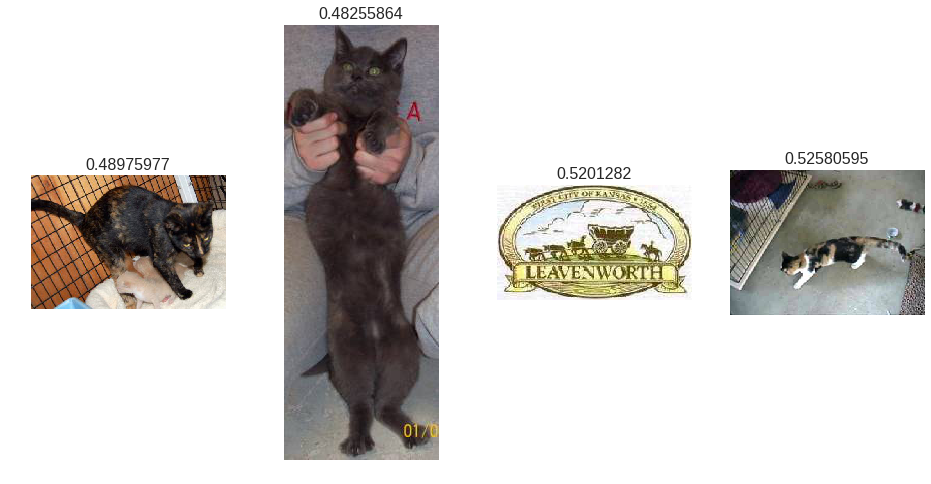

In [50]:
# most uncertain probilities will be far lesser than 0.49
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [51]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [52]:
lrf = learn.lr_find()

 82%|████████▏ | 295/360 [00:07<00:01, 40.89it/s, loss=0.416]


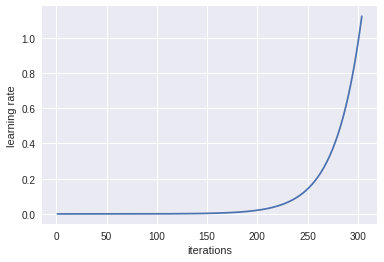

In [53]:
# learn object contains an attribute sched that contains our learning rate 
# scheduler, and has some convenient plotting functionality including this one:
learn.sched.plot_lr()

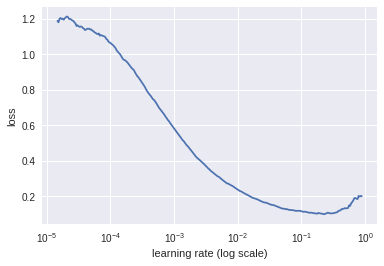

In [54]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use.

## Improving the model

### Data Augmentation

In [55]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [56]:
# Prepares Data plus Augmented data for all images
data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
def get_augs(count):
    # outputs FloatTensor (which consits 6 ndarrays, each containing
    # 224x224x3 dimensional array) (6 images)
    x,_ = next(iter(data.aug_dl))
    if (count == 1):
        # print(x[0].shape)
        print(x)
    # Converts(FloatTensor) and returns ndArray
    return data.trn_ds.denorm(x)[1]

In [57]:
# len 6 numpy.ndarray each consisting of 224x224x3 ndArray
ims = np.stack([get_augs(1 if i == 0 else 0) for i in range(6)])


( 0 , 0 ,.,.) = 
 -1.0915e+00 -1.0356e+00 -8.3299e-01  ...  -9.8432e-01 -9.6261e-01 -9.8917e-01
 -1.1977e+00 -1.0992e+00 -8.8068e-01  ...  -1.0435e+00 -1.0318e+00 -1.0313e+00
 -1.2679e+00 -1.1519e+00 -1.0035e+00  ...  -9.7209e-01 -9.7914e-01 -9.9930e-01
                 ...                   ⋱                   ...                
  4.9038e-01 -1.9269e-01 -6.8542e-01  ...  -1.3235e+00 -1.2687e+00 -1.0906e+00
  5.5444e-01 -8.9246e-02 -6.4108e-01  ...  -1.1905e+00 -1.3440e+00 -1.0285e+00
  5.6367e-01 -4.3274e-02 -5.9325e-01  ...  -1.1463e+00 -1.3034e+00 -9.5697e-01

( 0 , 1 ,.,.) = 
 -7.3215e-01 -7.0557e-01 -5.3577e-01  ...  -5.5172e-01 -5.3292e-01 -5.6167e-01
 -8.3178e-01 -7.6563e-01 -5.7772e-01  ...  -5.9253e-01 -5.8619e-01 -5.8768e-01
 -8.8314e-01 -8.1613e-01 -7.0021e-01  ...  -4.9836e-01 -5.1838e-01 -5.4654e-01
                 ...                   ⋱                   ...                
  6.4068e-01 -4.9894e-02 -5.5330e-01  ...  -8.8423e-01 -8.0655e-01 -5.9241e-01
  7.0379e-01  4.

In [58]:
# A single image data
ims[0].shape

(224, 224, 3)

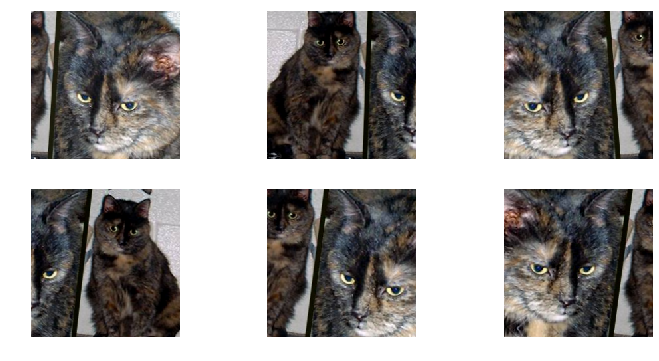

In [59]:
# Plots 6 images maintaining 2 rows
plots(ims, rows=2)

In [60]:
# Fresh start
# Generate Augmented Data
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
# Learner to train only the last (new) layer(since model is freezed)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [61]:
# Train the Last layer (only update weights in the last layer)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.049824   0.030676   0.989     



[array([0.03068]), 0.989]

In [62]:
# Use Stochastic Gradient Descent with Restarts
# The number of epochs between resetting the learning rate is set
# by cycle_len, and the number of times this happens is refered to
# as the number of cycles,
# Number of Epochs depend on cycle_len
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.042455   0.033405   0.988     
    1      0.04072    0.030196   0.989     
    2      0.047498   0.03027    0.9905    



[array([0.03027]), 0.9905]

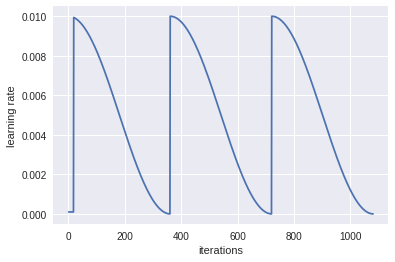

In [63]:
# Plot Learning rate
learn.sched.plot_lr()

In [64]:
# Our validation loss isn't improving much, so there's probably no point
# further training the last layer on its own.
# Save weights in tmp folder so it can be loaded later.
learn.save('224_lastlayer')

In [65]:
learn.load('224_lastlayer')

In [66]:
# Now that we have a good final layer trained, we can try fine-tuning 
# the other layers.
# unfreeze the remaining layers,
learn.unfreeze()

In [67]:
# Differential Learning rates
# Earlier Layers require less fine tuning since they already grasp the general structure
# Therefore we would expect them to need less fine-tuning for new datasets.
lr = np.array([1e-4, 1e-3, 1e-2])

In [68]:
# Start training over all the layers
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.042845   0.028538   0.9885    
    1      0.038487   0.030298   0.9885    
    2      0.041734   0.03098    0.988     
    3      0.044552   0.029817   0.9895    
    4      0.03872    0.028137   0.99      
    5      0.036129   0.027274   0.991     
    6      0.039173   0.02747    0.991     



[array([0.02747]), 0.991]

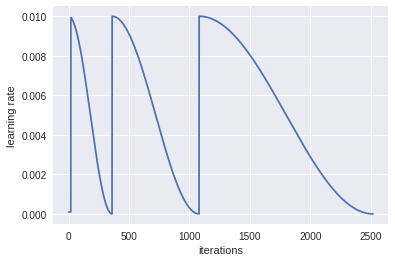

In [69]:
# Learning rate for final layers
learn.sched.plot_lr()

In [70]:
# Save Weights
learn.save('224_all')

In [71]:
# Load Weights
learn.load('224_all')

In [72]:
# Perform Test Time Augementation
log_preds, y = learn.TTA()

In [74]:
# This generates 4 Augmentations from a original image
# For each 2000 set it stores it predictions, in total 5 x 2000 (predictions)
# each prediction is [ , ] ndArrary
# 5 x 2000 x 2
log_preds[0][:2]

array([[-0.01196, -4.43249],
       [-0.00011, -9.10862]], dtype=float32)

In [76]:
# Compute probabilities 
probs = np.mean(np.exp(log_preds), 0)

In [78]:
probs[:5]

array([[0.99146, 0.00854],
       [0.99744, 0.00256],
       [0.99988, 0.00012],
       [0.9997 , 0.0003 ],
       [0.27709, 0.72291]], dtype=float32)

In [80]:
y[:5]

array([0, 0, 0, 0, 0])

In [81]:
np.exp(log_preds)[0][:2]

array([[0.98812, 0.01188],
       [0.99989, 0.00011]], dtype=float32)

In [85]:
#np.mean(np.exp(log_preds[:, 0][0]))
log_preds[:, 0][:, 0]

array([-0.01196, -0.00171, -0.00797, -0.00441, -0.0169 ], dtype=float32)

In [86]:
# below is mean(origingal + augmented) of log_preds for cats
np.mean(np.exp(log_preds[:, 0][:, 0]))

0.99146116

In [87]:
accuracy_np(probs,y)

0.992

In [88]:
# Returns indices of the max, 0 for cats and 1 for dogs
preds = np.argmax(probs, axis=1)

In [89]:
preds[:5]

array([0, 0, 0, 0, 1])

In [90]:
probs[:, 1] #Pr for dogs 

array([0.00854, 0.00256, 0.00012, ..., 0.99998, 0.99994, 0.9999 ], dtype=float32)

In [91]:
probs[:, 0] #Pr for Cats

array([0.99146, 0.99744, 0.99988, ..., 0.00002, 0.00006, 0.0001 ], dtype=float32)

### Confusion Matrix

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[990  10]
 [  6 994]]


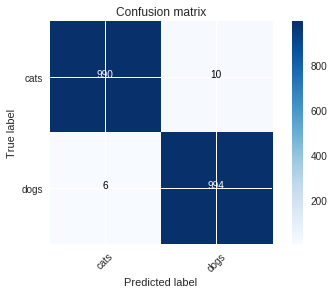

In [97]:
plot_confusion_matrix(cm, data.classes)